We explore a few locality-preserving dimensionality reduction methods:  
- Locality Preserving Projections (LPP) [1, 2]
- Orthogonal Locality Preserving Projections (OLPP) [3]
- Neighborhood preserving projection (NPP), also known as neighborhood preserving embedding [3, 4]
- Orthogonal Neighborhood Preserving Projections (ONPP) [3]

These methods learn locality (neighborhood) preserving linear projections that are defined everywhere, i.e. they can be applied to new test data points, unlike methods like locally linear embedding (LLE), Laplacian eigenmaps, and IsoMap (which are defined only on the data points used to learn the embedding). They are different from global linear methods like PCA, whose goal is to find the projections directions along which the variance of the data is maximized.

#### References
1. He, Xiaofei, and Partha Niyogi. "Locality preserving projections." Advances in neural information processing
systems. 2004.
2. He, Xiaofei, et al. "Face recognition using LaplacianFaces." IEEE Transactions on Pattern Analysis & Machine
Intelligence 3 (2005): 328-340.
3. Kokiopoulou, Effrosyni, and Yousef Saad. "Orthogonal neighborhood preserving projections: A projection-based
dimensionality reduction technique." IEEE Transactions on Pattern Analysis and Machine Intelligence
29.12 (2007): 2143-2156.
4. He, Xiaofei, et al. "Neighborhood preserving embedding." Tenth IEEE International Conference on Computer 
Vision (ICCV'05) Volume 1. Vol. 2. IEEE, 2005.

In [1]:
import numpy as np
from multiprocessing import cpu_count
from dimension_reduction_methods import (
    LocalityPreservingProjection, 
    NeighborhoodPreservingProjection, 
    pca_wrapper
)
from localized_pvalue_estimation import averaged_KLPE_anomaly_detection
from sklearn.metrics import (
    roc_curve, 
    precision_recall_curve
)
from utils import (
    wrapper_data_generate, 
    metrics_detection
)
from sklearn import datasets
from sklearn.utils import check_random_state
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

%matplotlib inline

In [2]:
def project_wrapper(data, method, data_test=None, metric='euclidean', snn=False, ann=True, dim_proj=3):
    n_jobs = max(cpu_count() - 2, 1)
    seed_rng = np.random.randint(1, high=10000)
    # Choices are {'simple', 'SNN', 'heat_kernel'}
    edge_weights = 'heat_kernel'

    # Neighborhood size is chosen as a function of the number of data points. 
    # In [1], it is recommended to chose `k = n^{2 / 5} = n^0.4`
    neighborhood_constant = 0.4
    
    if method == 'LPP' or method == 'OLPP':
        model = LocalityPreservingProjection(
            dim_projection=dim_proj, 
            orthogonal=(method == 'OLPP'), 
            pca_cutoff=1.0, 
            neighborhood_constant=neighborhood_constant, 
            shared_nearest_neighbors=snn, 
            edge_weights=edge_weights,
            metric=metric, 
            approx_nearest_neighbors=ann, 
            n_jobs=n_jobs, 
            seed_rng=seed_rng
        )
        model.fit(data)
        data_proj = model.transform(data)
        if data_test is None:
            data_proj_test = None
        else:
            data_proj_test = model.transform(data_test)
        
    elif method == 'NPP' or method == 'ONPP':
        model = NeighborhoodPreservingProjection(
            dim_projection=dim_proj, 
            orthogonal=(method == 'ONPP'), 
            pca_cutoff=1.0, 
            neighborhood_constant=neighborhood_constant, 
            shared_nearest_neighbors=snn,
            metric=metric, 
            approx_nearest_neighbors=ann, 
            n_jobs=n_jobs, 
            seed_rng=seed_rng
        )
        model.fit(data)
        data_proj = model.transform(data)
        if data_test is None:
            data_proj_test = None
        else:
            data_proj_test = model.transform(data_test)
        
    elif method == 'PCA':
        data_proj, mean_data, transform_pca = pca_wrapper(data, n_comp=dim_proj, seed_rng=seed_rng)
        if data_test is None:
            data_proj_test = None
        else:
            data_proj_test = np.dot(data_test - mean_data, transform_pca)
        
    else:
        raise ValueError("Invalid value '{}' received by parameter 'method'".format(method))
    
    return data_proj, data_proj_test


In [3]:
# Define some constants
methods_list = ['LPP', 'OLPP', 'NPP', 'ONPP', 'PCA']
n_jobs = max(cpu_count() - 2, 1)
seed_rng = np.random.randint(1, high=10000)
metric_primary = 'cosine'
shared_nearest_neighbors = True
# Choices are {'simple', 'SNN', 'heat_kernel'}
edge_weights = 'heat_kernel'

# Neighborhood size is chosen as a function of the number of data points. 
# In [1], it is recommended to chose `k = n^{2 / 5} = n^0.4`
neighborhood_constant = 0.4

COLORS = ['r', 'b', 'g', 'y', 'orange', 'm', 'lawngreen', 'gold', 'c', 'hotpink']

In [4]:
# Generate synthetic data according to a mixture of factor analysis (MFA) model
np.random.seed(seed_rng)

# number of mixture components
n_components = 10
# dimension of the observed space
dim = 100
# Specify a range for the latent dimension
dim_latent_range = (10, 20)

# Number of training points, test points, and proportion of anomalies in the test data
N = 1000
N_test = 1000
prop_anomaly = 0.1

data, data_test, labels_test = wrapper_data_generate(dim, dim_latent_range, n_components, 
                                                     N, N_test, prop_anomaly=prop_anomaly, 
                                                     anom_type='gaussian', seed_rng=seed_rng)
data_proj = dict()
data_test_proj = dict()

INFO:dimension_reduction_methods:Applying PCA as first-level dimension reduction step
INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 100
INFO:dimension_reduction_methods:Number of principal components accounting for 100.0 percent of the data variance = 100
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 100
INFO:dimension_reduction_methods:Dimension of the projected subspace = 3
INFO:dimension_reduction_methods:Solving the generalized eigenvalue problem to find the optimal projection matrix.


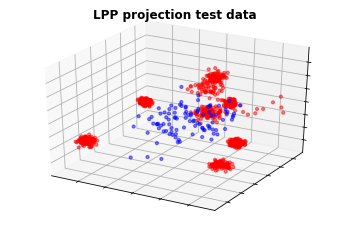

INFO:dimension_reduction_methods:Applying PCA as first-level dimension reduction step
INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 100
INFO:dimension_reduction_methods:Number of principal components accounting for 100.0 percent of the data variance = 100
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 100
INFO:dimension_reduction_methods:Dimension of the projected subspace = 3
INFO:dimension_reduction_methods:Solving the generalized eigenvalue problem to find the optimal projection matrix.


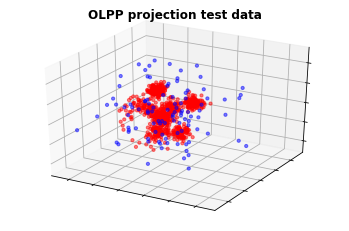

INFO:dimension_reduction_methods:Applying PCA as first-level dimension reduction step
INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 100
INFO:dimension_reduction_methods:Number of principal components accounting for 100.0 percent of the data variance = 100
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 100
INFO:dimension_reduction_methods:Dimension of the projected subspace = 3
INFO:dimension_reduction_methods:Solving the generalized eigenvalue problem to find the optimal projection matrix.


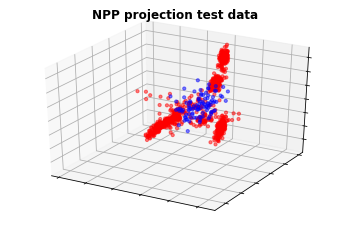

INFO:dimension_reduction_methods:Applying PCA as first-level dimension reduction step
INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 100
INFO:dimension_reduction_methods:Number of principal components accounting for 100.0 percent of the data variance = 100
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 100
INFO:dimension_reduction_methods:Dimension of the projected subspace = 3
INFO:dimension_reduction_methods:Solving the generalized eigenvalue problem to find the optimal projection matrix.


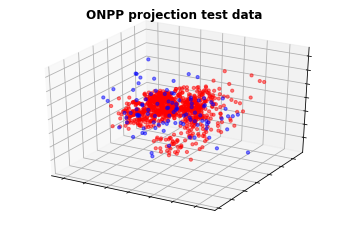

INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 100
INFO:dimension_reduction_methods:Number of principal components accounting for 100.0 percent of the data variance = 100
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 3


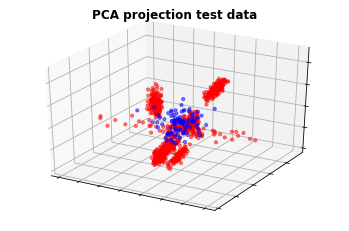

In [5]:
c = [COLORS[v] for v in labels_test]
for method in methods_list:
    _, data_proj = project_wrapper(data, method, data_test=data_test, metric='cosine', 
                                   snn=True, ann=True, dim_proj=3)
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data_proj[:, 0], data_proj[:, 1], data_proj[:, 2], marker='o', c=c, s=10, alpha=0.5)
    ax.set_title('{} projection test data'.format(method), fontweight='bold')
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.zaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')
    plt.show()

In [6]:
def project_synthetic_data(data, colors, name_str):
    # Plot the original data in 3d
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=colors, cmap=plt.cm.rainbow)
    ax.set_title('{} data'.format(name_str), fontweight='bold')
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.zaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')
    plt.show()
    
    # Project the data to 2d using different methods and plot
    for method in methods_list:
        data_proj, _ = project_wrapper(data, method, metric='euclidean', snn=False, ann=True, dim_proj=2)
        
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.scatter(data_proj[:, 0], data_proj[:, 1], c=colors, cmap=plt.cm.rainbow)
        ax.set_title('{} projection of {} data'.format(method, name_str), fontweight='bold')
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        plt.axis('tight')
        plt.show()


### Projection of S-curve data

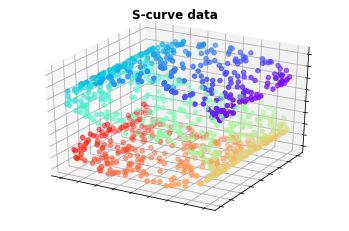

INFO:dimension_reduction_methods:Applying PCA as first-level dimension reduction step
INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 3
INFO:dimension_reduction_methods:Number of principal components accounting for 100.0 percent of the data variance = 3
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 3
INFO:dimension_reduction_methods:Dimension of the projected subspace = 2
INFO:dimension_reduction_methods:Solving the generalized eigenvalue problem to find the optimal projection matrix.


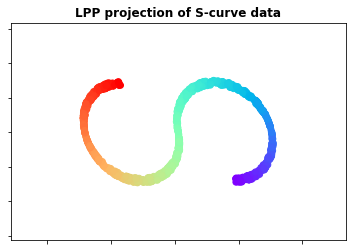

INFO:dimension_reduction_methods:Applying PCA as first-level dimension reduction step
INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 3
INFO:dimension_reduction_methods:Number of principal components accounting for 100.0 percent of the data variance = 3
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 3
INFO:dimension_reduction_methods:Dimension of the projected subspace = 2
INFO:dimension_reduction_methods:Solving the generalized eigenvalue problem to find the optimal projection matrix.


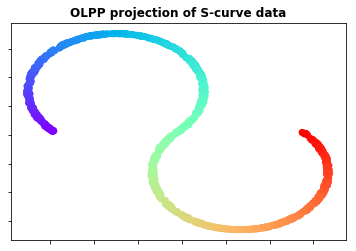

INFO:dimension_reduction_methods:Applying PCA as first-level dimension reduction step
INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 3
INFO:dimension_reduction_methods:Number of principal components accounting for 100.0 percent of the data variance = 3
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 3
INFO:dimension_reduction_methods:Dimension of the projected subspace = 2
INFO:dimension_reduction_methods:Solving the generalized eigenvalue problem to find the optimal projection matrix.


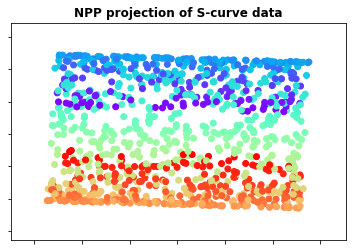

INFO:dimension_reduction_methods:Applying PCA as first-level dimension reduction step
INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 3
INFO:dimension_reduction_methods:Number of principal components accounting for 100.0 percent of the data variance = 3
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 3
INFO:dimension_reduction_methods:Dimension of the projected subspace = 2
INFO:dimension_reduction_methods:Solving the generalized eigenvalue problem to find the optimal projection matrix.


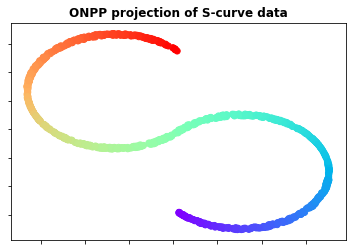

INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 3
INFO:dimension_reduction_methods:Number of principal components accounting for 100.0 percent of the data variance = 3
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 2


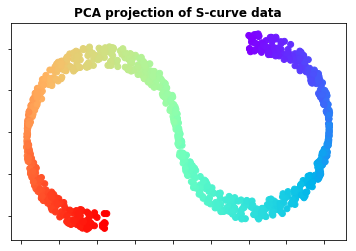

In [7]:
data, colors = datasets.make_s_curve(n_samples=N, random_state=seed_rng)
project_synthetic_data(data, colors, 'S-curve')

### Projection of Swiss roll data

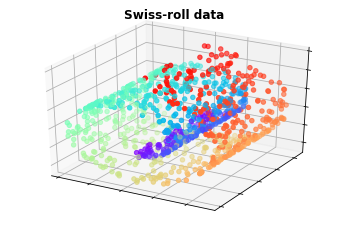

INFO:dimension_reduction_methods:Applying PCA as first-level dimension reduction step
INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 3
INFO:dimension_reduction_methods:Number of principal components accounting for 100.0 percent of the data variance = 3
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 3
INFO:dimension_reduction_methods:Dimension of the projected subspace = 2
INFO:dimension_reduction_methods:Solving the generalized eigenvalue problem to find the optimal projection matrix.


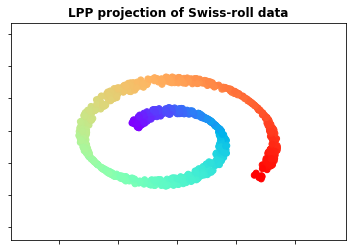

INFO:dimension_reduction_methods:Applying PCA as first-level dimension reduction step
INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 3
INFO:dimension_reduction_methods:Number of principal components accounting for 100.0 percent of the data variance = 3
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 3
INFO:dimension_reduction_methods:Dimension of the projected subspace = 2
INFO:dimension_reduction_methods:Solving the generalized eigenvalue problem to find the optimal projection matrix.


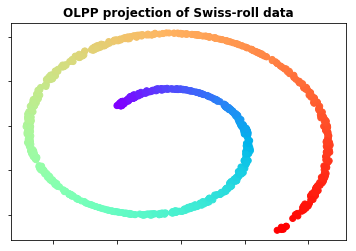

INFO:dimension_reduction_methods:Applying PCA as first-level dimension reduction step
INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 3
INFO:dimension_reduction_methods:Number of principal components accounting for 100.0 percent of the data variance = 3
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 3
INFO:dimension_reduction_methods:Dimension of the projected subspace = 2
INFO:dimension_reduction_methods:Solving the generalized eigenvalue problem to find the optimal projection matrix.


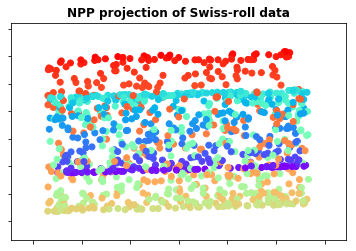

INFO:dimension_reduction_methods:Applying PCA as first-level dimension reduction step
INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 3
INFO:dimension_reduction_methods:Number of principal components accounting for 100.0 percent of the data variance = 3
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 3
INFO:dimension_reduction_methods:Dimension of the projected subspace = 2
INFO:dimension_reduction_methods:Solving the generalized eigenvalue problem to find the optimal projection matrix.


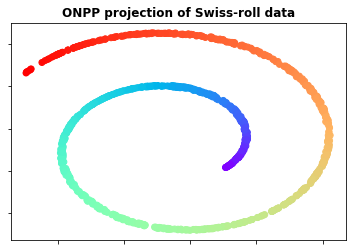

INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 3
INFO:dimension_reduction_methods:Number of principal components accounting for 100.0 percent of the data variance = 3
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 2


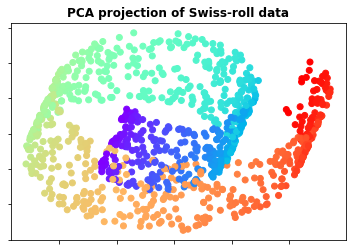

In [8]:
data, colors = datasets.make_swiss_roll(n_samples=N, random_state=seed_rng)
project_synthetic_data(data, colors, 'Swiss-roll')

### Severed sphere data

In [9]:
def generate_severed_sphere(n_samples=1000):
    # Create our sphere.
    random_state = check_random_state(0)
    p = random_state.rand(n_samples) * (2 * np.pi - 0.55)
    t = random_state.rand(n_samples) * np.pi

    # Sever the poles from the sphere.
    indices = ((t < (np.pi - (np.pi / 8))) & (t > ((np.pi / 8))))
    colors = p[indices]
    x, y, z = np.sin(t[indices]) * np.cos(p[indices]), np.sin(t[indices]) * np.sin(p[indices]), np.cos(t[indices])

    data = np.array([x, y, z]).T
    return data, colors

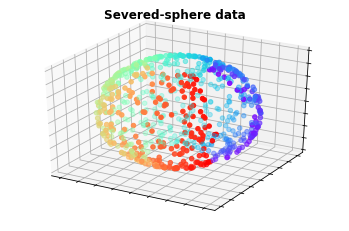

INFO:dimension_reduction_methods:Applying PCA as first-level dimension reduction step
INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 3
INFO:dimension_reduction_methods:Number of principal components accounting for 100.0 percent of the data variance = 3
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 3
INFO:dimension_reduction_methods:Dimension of the projected subspace = 2
INFO:dimension_reduction_methods:Solving the generalized eigenvalue problem to find the optimal projection matrix.


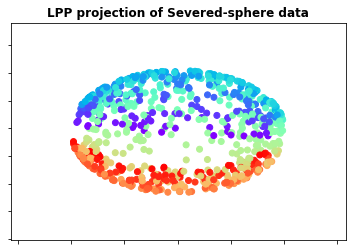

INFO:dimension_reduction_methods:Applying PCA as first-level dimension reduction step
INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 3
INFO:dimension_reduction_methods:Number of principal components accounting for 100.0 percent of the data variance = 3
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 3
INFO:dimension_reduction_methods:Dimension of the projected subspace = 2
INFO:dimension_reduction_methods:Solving the generalized eigenvalue problem to find the optimal projection matrix.


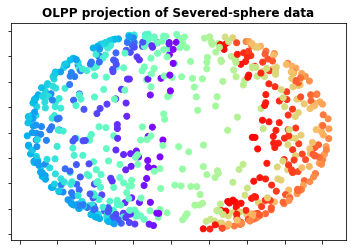

INFO:dimension_reduction_methods:Applying PCA as first-level dimension reduction step
INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 3
INFO:dimension_reduction_methods:Number of principal components accounting for 100.0 percent of the data variance = 3
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 3
INFO:dimension_reduction_methods:Dimension of the projected subspace = 2
INFO:dimension_reduction_methods:Solving the generalized eigenvalue problem to find the optimal projection matrix.


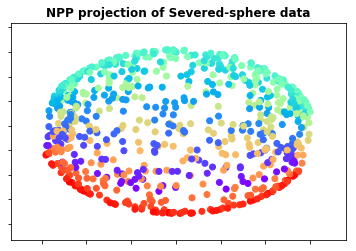

INFO:dimension_reduction_methods:Applying PCA as first-level dimension reduction step
INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 3
INFO:dimension_reduction_methods:Number of principal components accounting for 100.0 percent of the data variance = 3
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 3
INFO:dimension_reduction_methods:Dimension of the projected subspace = 2
INFO:dimension_reduction_methods:Solving the generalized eigenvalue problem to find the optimal projection matrix.


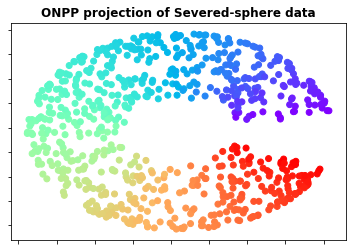

INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 3
INFO:dimension_reduction_methods:Number of principal components accounting for 100.0 percent of the data variance = 3
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 2


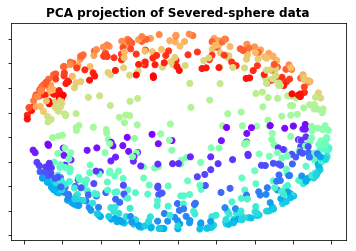

In [10]:
data, colors = generate_severed_sphere(n_samples=N)
project_synthetic_data(data, colors, 'Severed-sphere')

### MNIST data

In [11]:
from sklearn.datasets import fetch_openml

data_all, labels_all = fetch_openml('mnist_784', version=1, return_X_y=True)

# Recode the labels as integers for convenience
vs = np.unique(labels_all)
trans_label = dict(zip(vs, np.arange(vs.shape[0])))
labels_all = np.array([trans_label[a] for a in labels_all], dtype=np.int)

# Scale the feature values to the range [0, 1]
data_all = data_all / 255.

In [12]:
# Take a subset of the samples
data = data_all[:10000, :]
labels = labels_all[:10000]
data_test = data_all[10000:20000, :]
labels_test = labels_all[10000:20000]

N, d = data.shape
print("Number of training samples = {:d}. Number of features = {:d}.".format(N, d))

label_set, label_counts = np.unique(labels, return_counts=True)
print("Number of samples per class:")
print(label_counts)

Number of training samples = 10000. Number of features = 784.
Number of samples per class:
[1001 1127  991 1032  980  863 1014 1070  944  978]


INFO:dimension_reduction_methods:Applying PCA as first-level dimension reduction step
INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 784
INFO:dimension_reduction_methods:Number of principal components accounting for 100.0 percent of the data variance = 664
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 664
INFO:dimension_reduction_methods:Dimension of the projected subspace = 3
INFO:dimension_reduction_methods:Solving the generalized eigenvalue problem to find the optimal projection matrix.


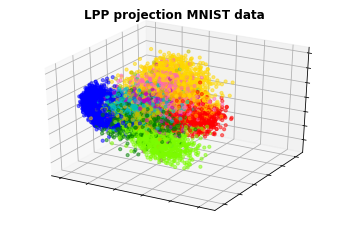

INFO:dimension_reduction_methods:Applying PCA as first-level dimension reduction step
INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 784
INFO:dimension_reduction_methods:Number of principal components accounting for 100.0 percent of the data variance = 664
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 664
INFO:dimension_reduction_methods:Dimension of the projected subspace = 3
INFO:dimension_reduction_methods:Solving the generalized eigenvalue problem to find the optimal projection matrix.


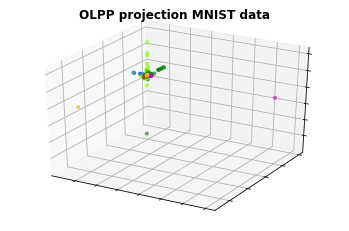

INFO:dimension_reduction_methods:Applying PCA as first-level dimension reduction step
INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 784
INFO:dimension_reduction_methods:Number of principal components accounting for 100.0 percent of the data variance = 664
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 664
INFO:dimension_reduction_methods:Dimension of the projected subspace = 3
INFO:dimension_reduction_methods:Solving the generalized eigenvalue problem to find the optimal projection matrix.


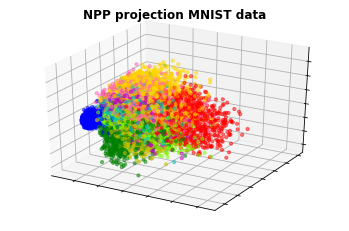

INFO:dimension_reduction_methods:Applying PCA as first-level dimension reduction step
INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 784
INFO:dimension_reduction_methods:Number of principal components accounting for 100.0 percent of the data variance = 664
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 664
INFO:dimension_reduction_methods:Dimension of the projected subspace = 3
INFO:dimension_reduction_methods:Solving the generalized eigenvalue problem to find the optimal projection matrix.


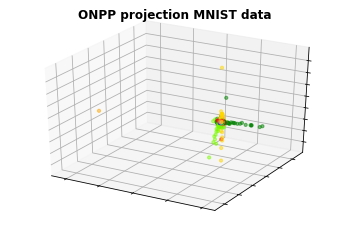

INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 784
INFO:dimension_reduction_methods:Number of principal components accounting for 100.0 percent of the data variance = 664
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 3


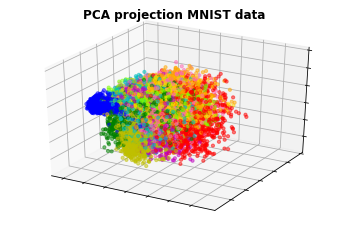

In [13]:
# Scatter plot of the 3D projection
label_map = {v: i for i, v in enumerate(label_set)}
c = [COLORS[label_map[v]] for v in labels]
for method in methods_list:
    data_proj, _ = project_wrapper(data, method, metric='cosine', snn=False, ann=True, dim_proj=3)
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data_proj[:, 0], data_proj[:, 1], data_proj[:, 2], marker='o', c=c, s=10, alpha=0.5)
    ax.set_title('{} projection MNIST data'.format(method), fontweight='bold')
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.zaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')
    plt.show()

#### Performance of a KNN classifier as a function of the projection dimension

In [14]:
from knn_index import KNNIndex
import numba
from scipy import stats

In [15]:
def knn_train(X, y, k, metric='euclidean', 
              shared_nearest_neighbors=False, approx_nearest_neighbors=True, 
              n_jobs=1, seed_rng=0):
    knn_model = dict()
    knn_model['labels'] = y
    knn_model['label_set'] = np.unique(y)
    knn_model['k'] = k
    # Create a KNN index
    knn_model['index'] = KNNIndex(
        X, n_neighbors=k,
        metric=metric,
        shared_nearest_neighbors=shared_nearest_neighbors,
        approx_nearest_neighbors=approx_nearest_neighbors,
        n_jobs=n_jobs,
        seed_rng=seed_rng
    )
    
    return knn_model

In [16]:
@numba.njit(fastmath=True)
def get_label_matrix(labels, indices):
    n, k = indices.shape
    label_mat = np.empty((n, k), dtype=labels.dtype)
    for i in range(n):
        for j in range(k):
            label_mat[i, j] = labels[indices[i, j]]
            
    return label_mat

In [17]:
def knn_predict(X, knn_model, is_train=False):
    nn_indices, nn_distances = knn_model['index'].query(X, k=knn_model['k'], exclude_self=is_train)
    labels_neighbors = get_label_matrix(knn_model['labels'], nn_indices)
    a, _ = stats.mode(labels_neighbors, axis=1)
    
    return a[:, 0]

In [18]:
def wrapper_knn(data, labels, data_test, labels_test, k, metric, shared_nearest_neighbors, n_jobs, seed_rng):
    knn_model = knn_train(data, labels, k, metric=metric, 
                          shared_nearest_neighbors=shared_nearest_neighbors, 
                          approx_nearest_neighbors=True, n_jobs=n_jobs, seed_rng=seed_rng)
    labels_pred_test = knn_predict(data_test, knn_model, is_train=False)
    
    # return error rate
    mask = labels_pred_test != labels_test
    return float(mask[mask].shape[0]) / labels_test.shape[0]

In [19]:
metric = 'cosine'
snn = False
n_neighbors = int(np.ceil(N ** neighborhood_constant))
dim_proj = 150

error_rate_test = dict()

In [20]:
# KNN classifier with all the features. 
# Applying PCA as pre-processing step to remove irrelevant features
data_proj, mean_data, transform_pca = pca_wrapper(data, cutoff=1.0, seed_rng=seed_rng)
data_test_proj = np.dot(data_test - mean_data, transform_pca)

# KNN classifier on the projected data
error_rate_test['all'] = wrapper_knn(data_proj, labels, data_test_proj, labels_test, 
                                     n_neighbors, metric, snn, n_jobs, seed_rng)

INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 784
INFO:dimension_reduction_methods:Number of principal components accounting for 100.0 percent of the data variance = 664
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 664


In [21]:
for method in methods_list:
    print("KNN classifier with dimension reduction using {}".format(method))
    data_proj, data_test_proj = project_wrapper(data, method, data_test=data_test, metric=metric, 
                                                snn=snn, ann=True, dim_proj=dim_proj)
    # KNN classifier on the projected data
    error_rate_test[method] = wrapper_knn(data_proj, labels, data_test_proj, labels_test, 
                                          n_neighbors, metric, snn, n_jobs, seed_rng)

INFO:dimension_reduction_methods:Applying PCA as first-level dimension reduction step


KNN classifier with dimension reduction using LPP


INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 784
INFO:dimension_reduction_methods:Number of principal components accounting for 100.0 percent of the data variance = 664
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 664
INFO:dimension_reduction_methods:Dimension of the projected subspace = 150
INFO:dimension_reduction_methods:Solving the generalized eigenvalue problem to find the optimal projection matrix.
INFO:dimension_reduction_methods:Applying PCA as first-level dimension reduction step


KNN classifier with dimension reduction using OLPP


INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 784
INFO:dimension_reduction_methods:Number of principal components accounting for 100.0 percent of the data variance = 664
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 664
INFO:dimension_reduction_methods:Dimension of the projected subspace = 150
INFO:dimension_reduction_methods:Solving the generalized eigenvalue problem to find the optimal projection matrix.
INFO:dimension_reduction_methods:Applying PCA as first-level dimension reduction step


KNN classifier with dimension reduction using NPP


INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 784
INFO:dimension_reduction_methods:Number of principal components accounting for 100.0 percent of the data variance = 664
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 664
INFO:dimension_reduction_methods:Dimension of the projected subspace = 150
INFO:dimension_reduction_methods:Solving the generalized eigenvalue problem to find the optimal projection matrix.
INFO:dimension_reduction_methods:Applying PCA as first-level dimension reduction step


KNN classifier with dimension reduction using ONPP


INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 784
INFO:dimension_reduction_methods:Number of principal components accounting for 100.0 percent of the data variance = 664
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 664
INFO:dimension_reduction_methods:Dimension of the projected subspace = 150
INFO:dimension_reduction_methods:Solving the generalized eigenvalue problem to find the optimal projection matrix.


KNN classifier with dimension reduction using PCA


INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 784
INFO:dimension_reduction_methods:Number of principal components accounting for 100.0 percent of the data variance = 664
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 150


In [22]:
print("method\terror_rate")
for m in (['all'] + methods_list):
    print("{}\t{:.6f}".format(m, error_rate_test[m]))


method	error_rate
all	0.081800
LPP	0.144100
OLPP	0.405200
NPP	0.141100
ONPP	0.259000
PCA	0.079500
